To DO:
* Make run equal to original simulate function

In [148]:
import jax
from jax import random
from jax import numpy as np
from jax import vmap, jit, grad
from jax.experimental import optimizers
import numpy as onp
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [149]:
# load data
import pickle

with open('go_nogo_200.pickle', 'rb') as handle:
    d = pickle.load(handle)
print(d.keys())
y_go = d['y_go'] #/ d['y_go'].max() # Normalize...
y_go[150:] = 0 
y_nogo = d['y_nogo'] * 0

dict_keys(['J0', 'J', 'w', 'I_go', 'I_nogo', 'y_go', 'y_nogo'])


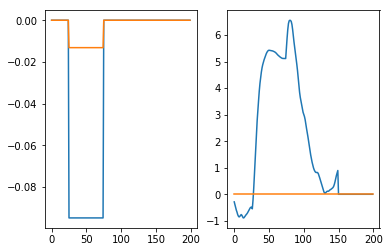

In [150]:
N = d['I_go'].shape[0]
Jinit = d['J0']
J = d['J']
w = d['w']
zN = np.zeros((25,N))
zNl = np.zeros((125,N))
z1 = np.zeros((1))
x_go = np.concatenate((zN, np.repeat(d['I_go'][None], axis=0, repeats=50), zNl))
x_nogo = np.concatenate((zN, np.repeat(d['I_nogo'][None], axis=0, repeats=50), zNl))
f, ax = plt.subplots(1, 2)
ax[0].plot(x_go.mean(1))
ax[0].plot(x_nogo.mean(1))
ax[1].plot(y_go)
ax[1].plot(y_nogo)

## Define network

In [151]:
def step_rnn(J, h, x):
    """ Perform one forward step """
    h = np.dot(J, h) + x
    return np.tanh(h)

def output(w, h):
    return np.dot(w, h)

batched_output = vmap(output, (None, 0))

def run(J, w, x_t):
    """ Simulate RNN for T time steps
        params : dict with keys J, w
        x_t : inputs, of shape (T, )
    """
    T, N = x_t.shape
    # Random initial condition
    key = random.PRNGKey(onp.random.randint(low=0, high=10**3))
    h = random.normal(key, shape=(N, ))
    h_t = []
    for x in x_t:
        h = 0.5 * h + np.dot(J, np.tanh(h)) + x #step_rnn(J, h, x)
        h_t.append(h)
    h_t = np.array(h_t)
    o_t = batched_output(w, np.tanh(h_t))
    return h_t, o_t

batched_run = vmap(run, (None, None,0))

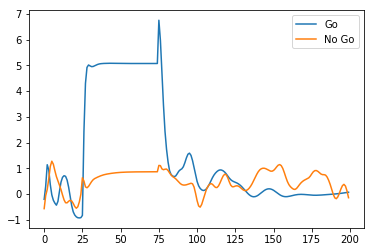

In [152]:
h_t, o_t = batched_run(d['J'], d['w'], x_go[None])
plt.plot(o_t[0], label = 'Go')
h_t, o_t = batched_run(d['J'], d['w'], x_nogo[None])
plt.plot(o_t[0], label = 'No Go')
plt.legend()

In [153]:
def compute_loss(J, w, inputs, targets):
    """ Inputs of size (nb_inputs, T, N) """
    _, outputs = batched_run(J, w, inputs)
    loss = np.mean((outputs - targets) ** 2)
    return loss

#loss_jit = jit(compute_loss)
#loss_jit(d['J'], d['w'], x_go[None], d['y_go'][None])

In [154]:
def update_weights(i, opt_state, opt_update, inputs, targets):
    J = optimizers.get_params(opt_state)
    def training_loss(J, w, x, y):
        return compute_loss(J,w,x,y)
    grads = grad(training_loss)(J,w,inputs,targets)
    return opt_update(i, grads, opt_state)

#update_weights_jit = jit(update_weights, static_argnums=(2,))

In [155]:
# Always show the same pattern
inputs = np.concatenate((x_go[None], x_nogo[None]))
targets = np.concatenate((y_go[None], y_nogo[None]))

In [187]:
gamma = 0.995
decay_fun = optimizers.exponential_decay(step_size=5e-4, decay_steps=1, decay_rate=gamma)
opt_init, opt_update = optimizers.adam(decay_fun) 
init_J = d['J0']
opt_state = opt_init(init_J)
#update_weights_jit(0, opt_state, opt_update, inputs, targets)

In [188]:
# don't jit, its super slow on cpu 
loss_hist = []
print_every = 10
for t in range(200):
    t0 = time.time()
    opt_state = update_weights(t, opt_state, opt_update, inputs, targets)
    t1 = time.time()
    if t % print_every == 0:
        J = optimizers.get_params(opt_state)
        l = compute_loss(J, w, inputs, targets)
        s = "Step {} in {:0.2f} sec, step size {:0.5f}, loss {:0.3f}"
        print(s.format(t, t1 - t0, decay_fun(t), l))
        loss_hist.append(l)
    

Step 0 in 1.16 sec, step size 0.00050, loss 4.497
Step 10 in 1.06 sec, step size 0.00048, loss 1.602
Step 20 in 1.08 sec, step size 0.00045, loss 0.513
Step 30 in 1.02 sec, step size 0.00043, loss 1.027
Step 40 in 0.86 sec, step size 0.00041, loss 0.321
Step 50 in 0.91 sec, step size 0.00039, loss 0.231
Step 60 in 1.06 sec, step size 0.00037, loss 0.132
Step 70 in 1.12 sec, step size 0.00035, loss 0.097
Step 80 in 0.87 sec, step size 0.00033, loss 0.154
Step 90 in 1.00 sec, step size 0.00032, loss 0.231
Step 100 in 0.89 sec, step size 0.00030, loss 0.065
Step 110 in 0.90 sec, step size 0.00029, loss 0.074
Step 120 in 0.88 sec, step size 0.00027, loss 0.067
Step 130 in 0.93 sec, step size 0.00026, loss 0.061
Step 140 in 0.91 sec, step size 0.00025, loss 0.107
Step 150 in 1.18 sec, step size 0.00024, loss 0.053
Step 160 in 1.00 sec, step size 0.00022, loss 0.068
Step 170 in 0.98 sec, step size 0.00021, loss 0.058
Step 180 in 0.92 sec, step size 0.00020, loss 0.039
Step 190 in 0.88 sec, s

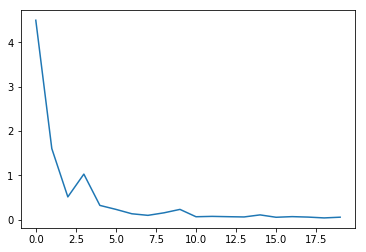

In [189]:
plt.plot(loss_hist)

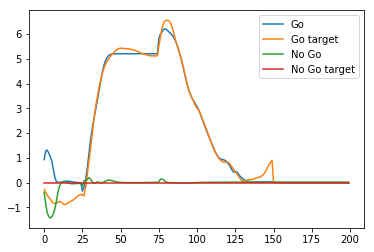

In [190]:
h_t, o_t = batched_run(J, d['w'], x_go[None])
plt.plot(o_t[0], label = 'Go')
plt.plot(y_go, label = 'Go target')
h_t, o_t = batched_run(J, d['w'], x_nogo[None])
plt.plot(o_t[0], label = 'No Go')
plt.plot(y_nogo, label = 'No Go target')

plt.legend()

0.26628383111256043


Text(0,0.5,'Trained update')

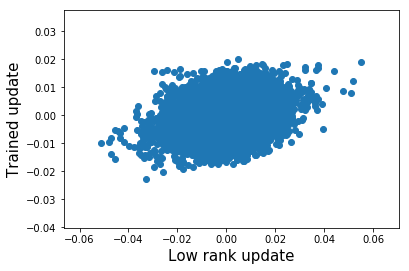

In [194]:
J_update = J - init_J
n = d['I_go'] 
m = d['w']
J_orig_update = 0.1*np.dot(m[:,None], n[None,:])
plt.scatter(J_orig_update.flatten(), J_update.flatten())
rho = onp.corrcoef(J_orig_update.flatten(), J_update.flatten())[0,1]
print(rho)
plt.xlabel("Low rank update", size=15)
plt.ylabel("Trained update", size=15)

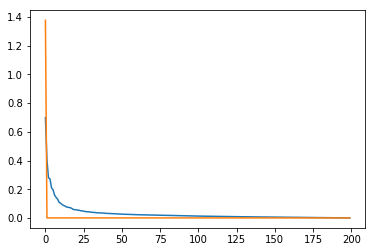

In [195]:
u1, s1, vh1 = onp.linalg.svd(J - Jinit, full_matrices=True)
plt.plot(s1,'-')
u2, s2, vh2 = onp.linalg.svd(d['J'] - d['J0'], full_matrices=True)
plt.plot(s2,'-')

-0.66324087422726


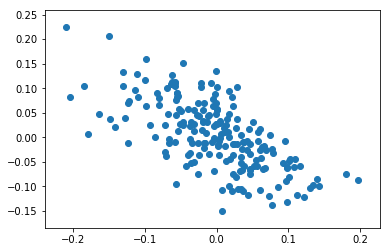

In [214]:
i = 0
plt.scatter(u1[:,i], u2[:,i])
print(onp.corrcoef(u1[:,i], u2[:,i])[0,1])